In [1]:
import os
import glob

In [2]:
base_dir = os.path.join('./cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
uninfected_dir = os.path.join(base_dir,'Uninfected')

In [3]:
infected_files = glob.glob(infected_dir+'/*.png')
uninfected_files = glob.glob(uninfected_dir+'/*.png')

In [4]:
len(infected_files)

13779

In [5]:
len(uninfected_files)

13779

In [6]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + uninfected_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(uninfected_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)


In [7]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values,
                                                                      test_size=0.4, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels,
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(14880,) (1654,) (11024,)
Train: Counter({'healthy': 7485, 'malaria': 7395}) 
Val: Counter({'malaria': 840, 'healthy': 814}) 
Test: Counter({'malaria': 5544, 'healthy': 5480})


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
x_train = train_datagen.flow_from_directory(r'C:\Users\Dell\Desktop\cell_images\cell_images',target_size=(64,64),batch_size=16,class_mode='binary')
x_test = test_datagen.flow_from_directory(r'C:\Users\Dell\Desktop\cell_images\cell_images',target_size=(64,64),batch_size=16,class_mode='binary')
print(x_train.class_indices)

Found 16324 images belonging to 2 classes.
Found 16324 images belonging to 2 classes.
{'testing': 0, 'training': 1}


In [9]:
img_width=64
img_height=64
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
"""model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(64,64,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,kernel_initializer='uniform',activation='relu'))
model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
"""
model=Sequential()
model.add(Conv2D(16,(3,3),input_shape=(img_width,img_height, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history=model.fit_generator(x_train,steps_per_epoch = 1000,epochs=5,validation_data=x_test,validation_steps=len(x_test))
model.save('mymodel.h5')

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1000/1000 [==============================] - 317s 317ms/step - loss: 0.6240 - accuracy: 0.6495 - val_loss: 0.6179 - val_accuracy: 0.6424
Epoch 2/5
1000/1000 [==============================] - 127s 127ms/step - loss: 0.5966 - accuracy: 0.6691 - val_loss: 0.6055 - val_accuracy: 0.6745
Epoch 3/5
1000/1000 [==============================] - 128s 128ms/step - loss: 0.5740 - accuracy: 0.6908 - val_loss: 0.5970 - val_accuracy: 0.6704
Epoch 4/5
1000/1000 [==============================] - 576s 576ms/step - loss: 0.5632 - accuracy: 0.6956 - val_loss: 0.5521 - val_accuracy: 0.7132
Epoch 5/5
1000/1000 [==============================] - 1366s 1s/step - loss: 0.5571 - accuracy: 0.7083 - val_loss: 0.5424 - val_accuracy: 0.7057


In [17]:
from tensorflow.keras.models import load_model
import cv2
model=load_model('mymodel.h5')

In [18]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [19]:
from skimage.transform import resize
def detect(frame):
    try:
        img=resize(frame,(64,64))
        img=np.expand_dims(img,axis=0)
        if(np.max(img)>1):
            img=img/255.0
        prediction=model.predict(img)
        print(prediction)
        prediction_class=model.predict_classes(img)
        print(prediction_class)
    except AttributeError:
        print('')

In [20]:
frame=cv2.imread('C1_thinF_IMG_20150604_104722_cell_15.png')
data=detect(frame)

In [21]:
import matplotlib.pyplot as plt

In [22]:
def plot_learningCurve(history,epoch):
    epoch_range=range(1,epoch+1)
    plt.plot(epoch_range,history.history['accuracy'])
    plt.plot(epoch_range,history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc='upper left')
    plt.show()
    
    plt.plot(epoch_range,history.history['loss'])
    plt.plot(epoch_range,history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc='upper left')
    plt.show()


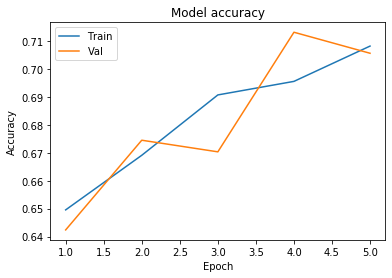

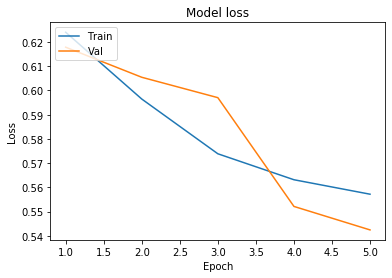

In [23]:
plot_learningCurve(history,5)